# Hyperparameterization with Keras
## A Hyperparameterized "Digit Classifier"
-----
Adapted from [Keras Tuner](https://www.tensorflow.org/tutorials/keras/keras_tuner)    
For more info on the steps taken here, read over the classify digits example.

## Step 0: Imports and Initialization

We'll use the exact same dataset and imports as our more basic example...

In [1]:
import tensorflow as tf
from tensorflow import keras
import IPython

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

...with one exception: the keras tuner

In [3]:
import kerastuner as kt

Take a look at our dataset first and make sure everything's OK. Then split it up into training and test sets.

In [4]:
# Our dataset
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [5]:
# For easier labeling, initalize the category names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

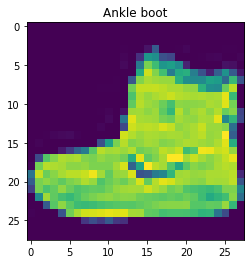

In [6]:
# An example image
plt.imshow(train_images[0])
plt.title(class_names[train_labels[0]]);

In [7]:
train_images = train_images/255.0
test_images = test_images/255.0

## Step 1: Building the Model

The Keras function for hyperparameters takes our model as a function, so we'll structure and compile the model in a function.

In [8]:
def create_model(hp):
    hp_units = hp.Int('units', min_value = 32, max_value = 512, step = 32)
    model = keras.Sequential([
        keras.layers.Flatten(input_shape=(28, 28)),
        keras.layers.Dense(activation='relu', units=hp_units),
        keras.layers.Dense(10)
    ])
    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    return model

In the function above, we use the exact same model as our basic example. Here, we tune our **units (layer size)** and  **learning rate**. Though you could tune other parameters, these two provide a good example of using some of our available hyperparameter options. Each one is given a name as the first parameter, which we'll refer to later.

Finally, we create the complete model, hyperparameters included, with the `Hyperband` method.

In [9]:
tuner = kt.Hyperband(create_model,
                     objective = 'val_accuracy', 
                     max_epochs = 10,
                     factor = 3)   

## Step 2: Training the Model

Even though we have our model set up, we still need to train it. Unsurprisingly, this process takes way longer than without hyperparameters. Feel free to watch a movie and come back to this step, it's going to take a while.

Note that there's a training callback to clear the notebook cell. Though it isn't necessary, it does prevent the cell output from getting too long. For more information about custon callbacks, see [the documentation](https://keras.io/guides/writing_your_own_callbacks/).

`tuner.search` has optional parameter `directory` in which it saves and resumes checkpoints. By default, it is `untitled_project`. If you find that your hyperparameter search is exiting early, it might be because Keras detects an existing directory of the same name and is attempting to resume from there. You may have to specify a different directory or deleting any previous checkpoints and try again.

In [10]:
clear_output = tf.keras.callbacks.Callback()
clear_output.on_epoch_end = lambda _, __: IPython.display.clear_output(wait=True)
tuner.search(train_images, train_labels, epochs = 10, validation_data = (test_images, test_labels), callbacks=[clear_output])

1875/1875 [==============================] - 6s 3ms/step - loss: 0.3027 - accuracy: 0.8924 - val_loss: 0.3602 - val_accuracy: 0.8738


INFO:tensorflow:Oracle triggered exit


We can view the results using the `get_best_hyperparameters` method. It returns an array of Hyperparameter objects, from which you can access your hyperpararmeters individually with their respective getters.

In [11]:
best_hps = tuner.get_best_hyperparameters()[0]
best_hps.get('units'), best_hps.get('learning_rate')

(416, 0.001)

Now that we have our hyperparameterized model, we still need to train it.     
Simply call build on the `hypermodel` with the hyperparameters found above. Then train it per the basic example.

In [12]:
model = tuner.hypermodel.build(best_hps)
model.fit(train_images, train_labels, epochs = 10)

Epoch 1/10
1875/1875 [==============================] - ETA: 0s - loss: 2.4009 - accuracy: 0.03 - ETA: 6s - loss: 1.5696 - accuracy: 0.45 - ETA: 7s - loss: 1.3107 - accuracy: 0.53 - ETA: 7s - loss: 1.1735 - accuracy: 0.57 - ETA: 7s - loss: 1.0947 - accuracy: 0.60 - ETA: 7s - loss: 1.0430 - accuracy: 0.62 - ETA: 7s - loss: 0.9677 - accuracy: 0.65 - ETA: 7s - loss: 0.9249 - accuracy: 0.66 - ETA: 7s - loss: 0.8866 - accuracy: 0.68 - ETA: 7s - loss: 0.8674 - accuracy: 0.69 - ETA: 7s - loss: 0.8490 - accuracy: 0.69 - ETA: 7s - loss: 0.8299 - accuracy: 0.70 - ETA: 7s - loss: 0.8149 - accuracy: 0.71 - ETA: 7s - loss: 0.8041 - accuracy: 0.71 - ETA: 7s - loss: 0.7907 - accuracy: 0.72 - ETA: 7s - loss: 0.7798 - accuracy: 0.72 - ETA: 7s - loss: 0.7728 - accuracy: 0.72 - ETA: 7s - loss: 0.7588 - accuracy: 0.73 - ETA: 7s - loss: 0.7461 - accuracy: 0.73 - ETA: 6s - loss: 0.7314 - accuracy: 0.74 - ETA: 6s - loss: 0.7172 - accuracy: 0.74 - ETA: 6s - loss: 0.7018 - accuracy: 0.75 - ETA: 6s - loss: 0.69

## Step 3: Testing the Model

In [13]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

313/313 - 1s - loss: 0.3294 - accuracy: 0.8839


Our accuracy is slightly more than the basic example. There likely wasn't much overfitting in either case, but this notebook demonstrates what modifications need to be made to add hyperparamterization in.